Elegimos un dataset de imagenes de cartas de poker. En el dataset aparecen 50 imagenes de cada carta. El objetivo es que la red nos indique el tipo de la carta.
Dataset cartas de poker Kaggle: [LINK
](https://https://www.kaggle.com/datasets/jaypradipshah/the-complete-playing-card-dataset/?select=annotation.json)
Dataset cartas de poker Drive: [LINK
](https://drive.google.com/drive/folders/1VYPk64LMwGWHEoiqdhQMxQfCnDbudIh2?usp=drive_link)

In [5]:
card_number = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']
card_type = ['C','D','S','H']
card_cant = 1 # Numero de imagenes por carta, ej: 20 significa que hay 20 imagenes del 10 de corazones
img_target_size = (84, 112) # Las images tienen un aspect ratio origial de 3/4. Tienen un alto de 3456p y ancho 4608p
path = '/content/drive/MyDrive/Images/'

#Preprocesado:

In [6]:
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.image import load_img
import pandas as pd
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, PReLU, InputLayer
from sklearn.model_selection import train_test_split
from keras.saving import load_model

In [7]:
from tensorflow import config
print(config.list_physical_devices('GPU'))
del config

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
def ReadImage(filename):
  img = load_img(path + filename + '.jpg', color_mode='grayscale', target_size = img_target_size)
  img = utils.img_to_array(img)
  img = img * 1/255 # Dividimos el valor de los pixeles por 255 para que el valor permanesca entre 1 y 0
  return img

Importamos el dataset a colab

In [10]:
images = []
for i in card_number:
  for j in card_type:
    for n in range(card_cant):
      img = ReadImage(i + j + str(n))
      images.append(img)

Creamos el array de salidas usando one hot encoding

In [11]:
#outputs = np.zeros((len(images), len(card_number) + len(card_type)), dtype = np.float32)
outputs_type = np.zeros((len(images), len(card_type)), dtype = np.float32)
outputs_number = np.zeros((len(images), len(card_number)), dtype = np.float32)
row = 0
for i in range(len(card_number)):
  for j in range(len(card_type)):
    for n in range(card_cant):
      outputs_number[row, i] = 1
      outputs_type[row, j] = 1
      row += 1

In [12]:
images[0].shape

(84, 112, 1)

Ejemplo de entrada:

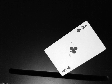

In [13]:
utils.array_to_img(images[0])

Ejemplo de salida (Cada numero corresponde a cual de los cuatro tipo de carta es):

In [14]:
outputs_type[0]

array([1., 0., 0., 0.], dtype=float32)

In [15]:
img_array = images[0]
images.pop(0)
img_array = np.moveaxis(img_array[:, None], 0, 1)

for img in images:
  img = np.moveaxis(img[:, None], 0, 1)
  img_array = np.concatenate((img_array, img), axis = 0)
del images

In [16]:
#X_mean = img_array.mean(axis=0)
#img_array -= X_mean
#X_std = img_array.std(axis=0)
#img_array /= X_std + 1e-8

In [17]:
print(img_array.shape)
print(img_array[0].shape)

(52, 84, 112, 1)
(84, 112, 1)


In [18]:
outputs_type.shape[-1]

4

In [19]:
def shuffle_in_unison_scary(a, b, c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [20]:
shuffle_in_unison_scary(img_array, outputs_type, outputs_number)

#Modelo para predecir tipo de carta

##Model Config

Creamos la estructura de la CNN y sus hyperparametros

In [21]:
model_type = Sequential()

#add model layers
model_type.add(InputLayer(input_shape=img_array[0].shape))

model_type.add(Conv2D(100, (5, 5), 1, activation='relu', input_shape=img_array[0].shape))
model_type.add(MaxPooling2D(pool_size=2))
model_type.add(BatchNormalization())
model_type.add(PReLU())
model_type.add(Dropout(0.1))

model_type.add(Conv2D(100, (3, 3), 1, activation='relu'))
model_type.add(BatchNormalization())
model_type.add(PReLU())
model_type.add(MaxPooling2D())
model_type.add(Dropout(0.1))

model_type.add(Conv2D(100, (3, 3), 1, activation='relu'))
model_type.add(BatchNormalization())
model_type.add(PReLU())
model_type.add(MaxPooling2D())
model_type.add(Dropout(0.1))

model_type.add(Flatten())
model_type.add(Dense(3000, activation='softmax'))
model_type.add(Dropout(0.3))
model_type.add(Dense(1000, activation='softmax'))
model_type.add(Dropout(0.3))
model_type.add(Dense(400, activation='softmax'))
model_type.add(Dropout(0.3))
model_type.add(Dense(outputs_type.shape[-1], activation='softmax'))

###Grafico

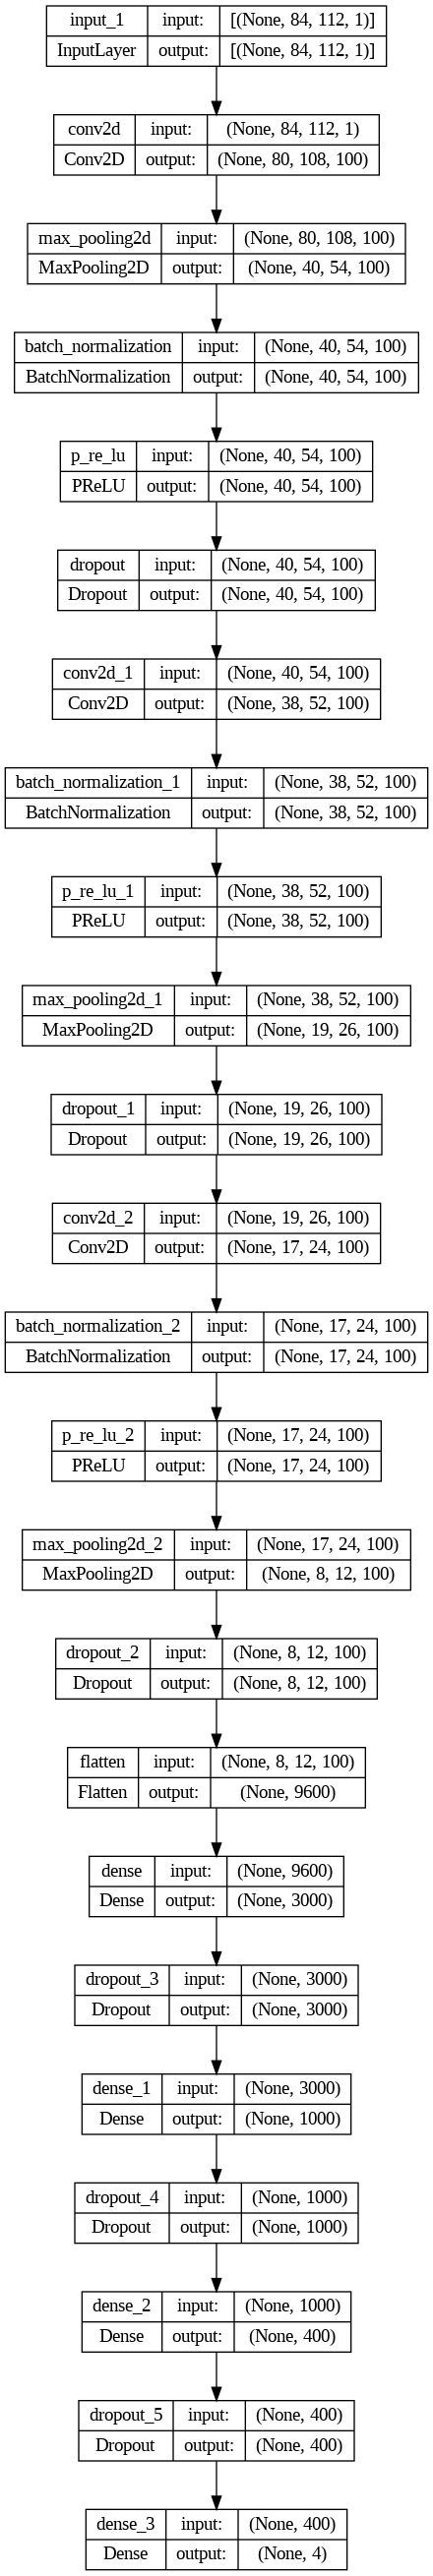

In [22]:
utils.plot_model(model_type, show_shapes=True)

##Entrenamiento

Dividimos el dataset en test y train

In [23]:
train_percentage = 0.75
trainX, testX = np.split(img_array,[int(train_percentage * img_array.shape[0])])
trainY, testY = np.split(outputs_type,[int(train_percentage * outputs_type.shape[0])])

Entrenamos el modelo usando stochastic gradient descent. Que es una forma de foward propagation. Y haciendo 600 epochs

In [24]:
model_type.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model_type.fit(trainX, trainY, validation_data=(testX, testY), epochs=1)

2/2 [==============================] - 16s 796ms/step - loss: 1.3860 - accuracy: 0.2564 - val_loss: 1.3883 - val_accuracy: 0.1538


Evaluamos este el modelo

In [25]:
model_type.evaluate(testX, testY)

1/1 [==============================] - 0s 31ms/step - loss: 1.3883 - accuracy: 0.1538


[1.3882626295089722, 0.1538461595773697]

##SaveModel

In [26]:
model_type.save('/content/drive/MyDrive/Images/Models/model_final_type.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Link al modelo ya entrenado, no es el mismo que aparece arriba:
https://drive.google.com/file/d/1-JPjE8LQfevngQ61ZtW6LGVV8wYWWs-5/view?usp=sharing

#Load and test model

Este modelo que entrene logre que tuviera una aquracy del 75%

In [27]:
model_type = Sequential()
model_type = load_model("/content/drive/MyDrive/Images/Models/model_final_type2.h5")
#model_type = load_model("/content/drive/MyDrive/model_final_type2.h5")

Para llegar a este modelo hubo muchas iteraciones. Lo primero que hice fue bajar la resolucion de las imagenes para que no ocupen tanto espacio.
Lo que hice fue acumular muchas layers de Conv2D + MaxPooling + BatchNormalazation + PReLU + Dropout.

La Conv2D la agregue porque era obligatorio para poder hacer una CNN y para extraerle las features a las imagenes. El maxpooling es necesario para bajarle la resolucion a las images ya que este proceso les baja mucho la resolucion. Pero creo que esto termina causando que se pierda informacion. Porque las figuras importantes son negras, entonces las partes blancas se superponen en las blancas.

Le agregue una layer de BatchNormalazation y PReLU porque habia leido que esto ayuda en las CNN para que se entrenen mejor. Y BatchNorm es util ponerlo entre las capas no lineales y las no lineales.
La capa de Dropout sirve para que la red generalise mas y que no dependa tanto en algunas neuronas para distingir objetos.

La cantidad de informacion que queda una vez que llegamos a la layer flatten son 2250 parametros. Hay en la primera capa de red neuronal:

5000 biases

11.250.000 weights

Por lo que creo que una version mejor tendria las layers de MaxPooling mas al final y mayor cantidad. Para que el resultado final de todas las convoluciones sea algo con menos datos pero de mayor valor para la red neuronal.

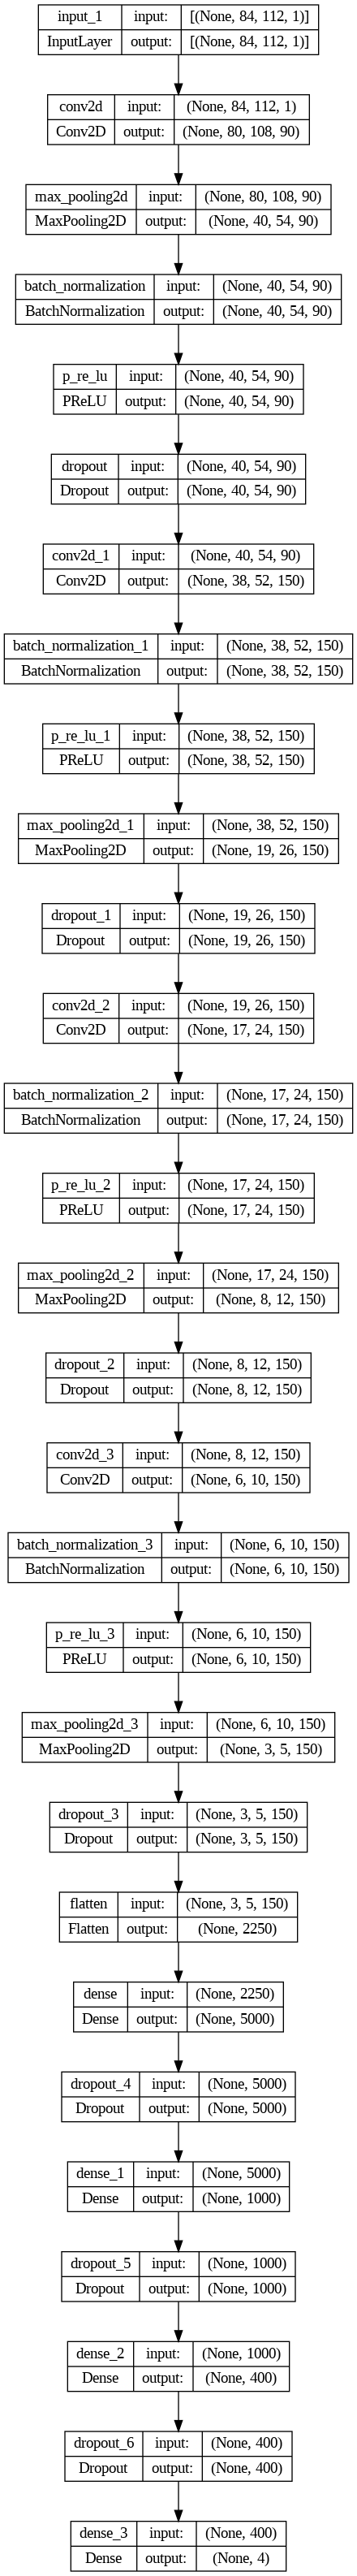

In [28]:
utils.plot_model(model_type, show_shapes=True)

##Predict

In [29]:
model_type.evaluate(img_array, outputs_type)

2/2 [==============================] - 1s 170ms/step - loss: 0.3550 - accuracy: 0.7500


[0.3549864888191223, 0.75]

In [30]:
a = model_type.predict(img_array)

2/2 [==============================] - 0s 12ms/step


##Compare images to predictions:

In [31]:
from matplotlib import pyplot as plt

In [32]:
def GetPred(array):
  tipo = ['Trébol','Diamante','Picas','Corazones ']
  max = 0
  for i in range(1, len(array)):
    if(array[i] > array[max]):
      max = i
  return tipo[max]

La red suele confundirse cuando se le muestra una imagen con diamantes y predice que es de corasones. Esto puede ser ya que la red usa los tonos de gris para dividir entre las cartas que eran rojas y las negras. Las cartas rojas como los corazones y diamantes tienen formas bastante parecidas, por lo que es logico que se confunda estas. En cambio las cartas negras tienen formas las cuales son mas faciles de distingir.

1 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


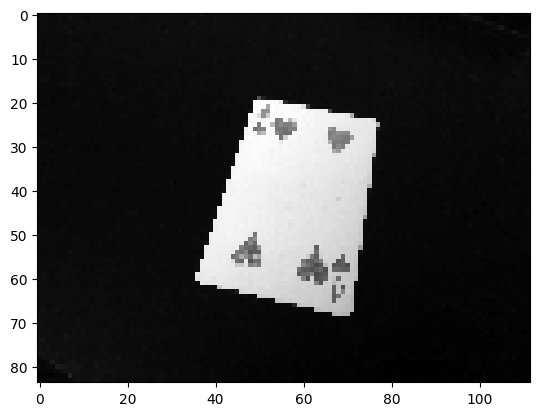

2 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


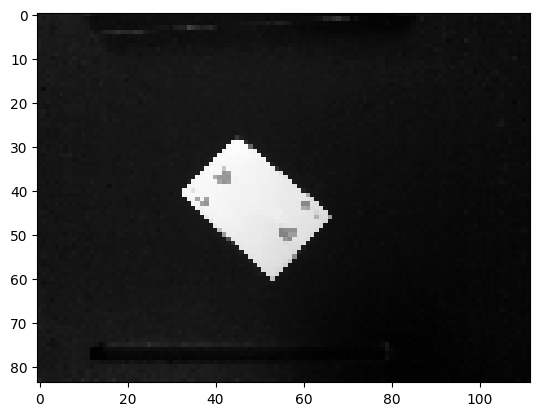

3 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


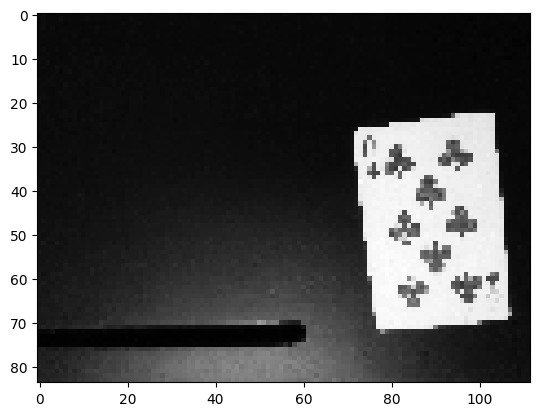

4 - Prediccion:  Picas  | Valor real:  Picas   |Image:


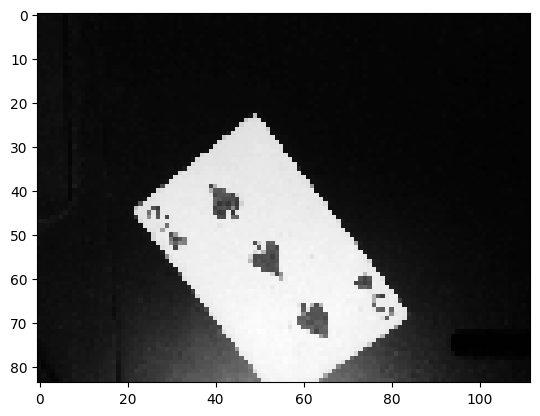

5 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


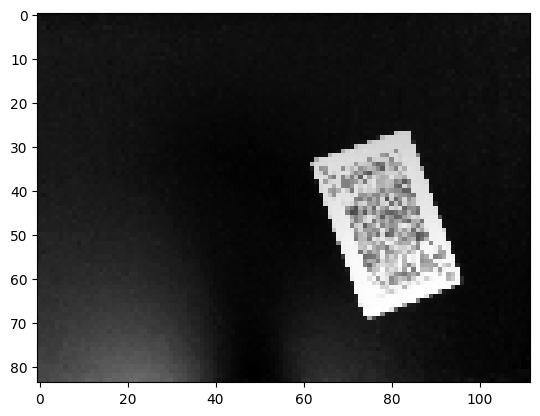

6 - Prediccion:  Picas  | Valor real:  Picas   |Image:


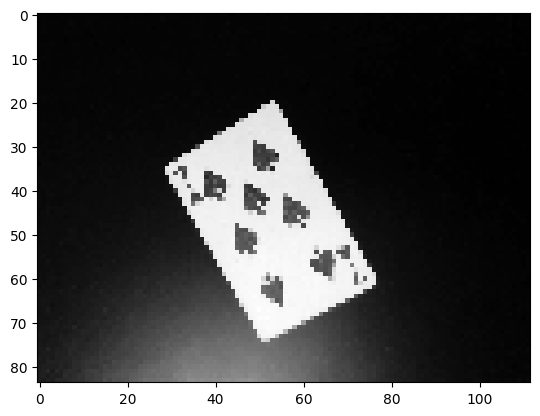

7 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


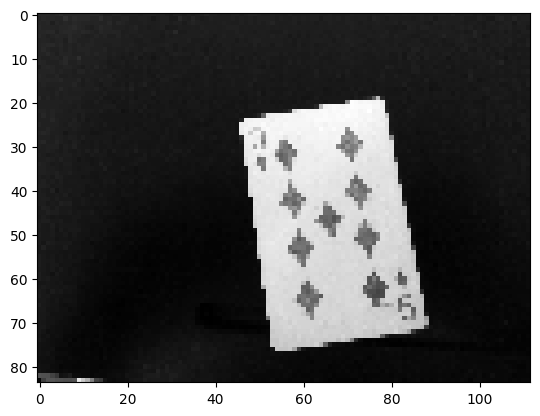

8 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


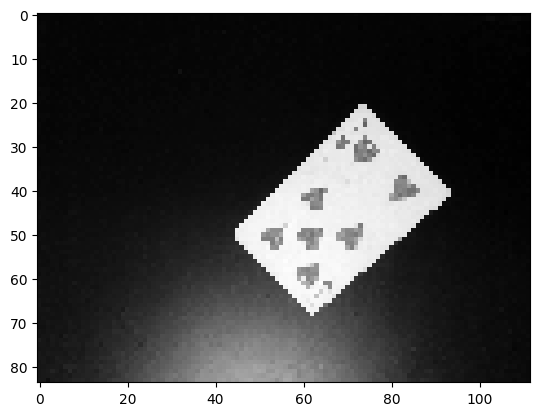

9 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


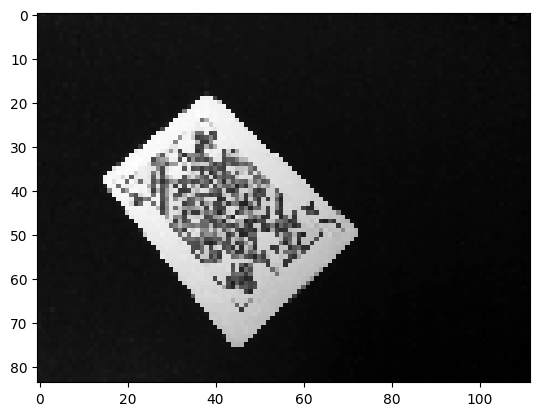

10 - Prediccion:  Picas  | Valor real:  Picas   |Image:


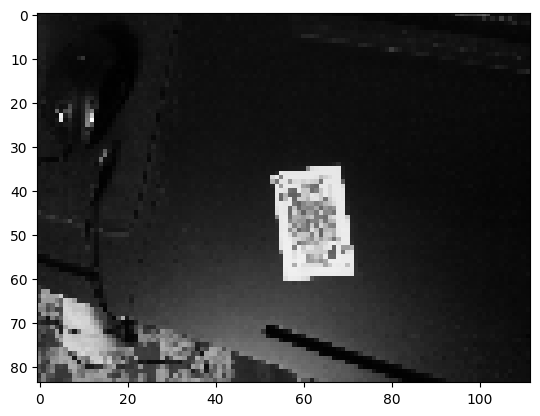

11 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


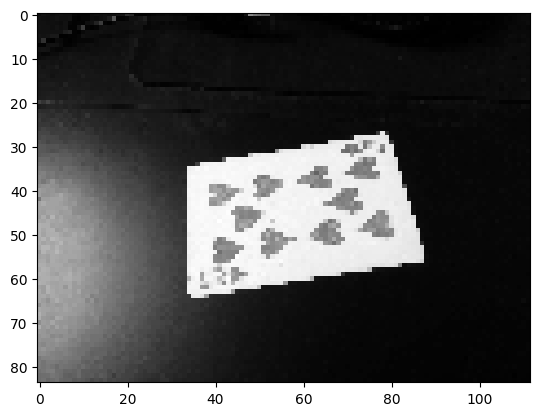

12 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


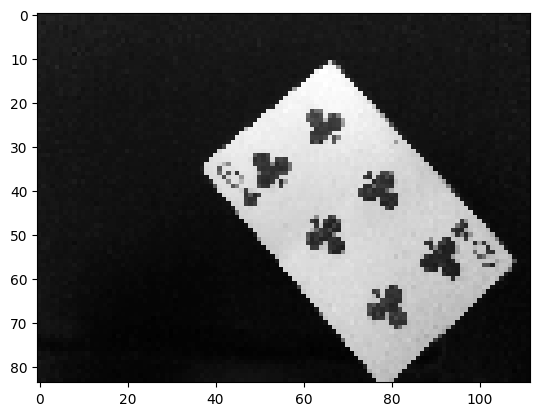

13 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


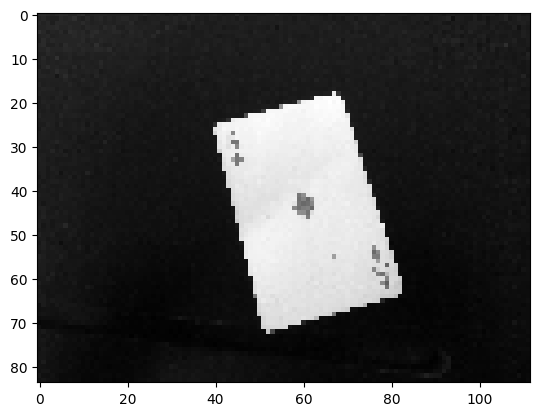

14 - Prediccion:  Picas  | Valor real:  Picas   |Image:


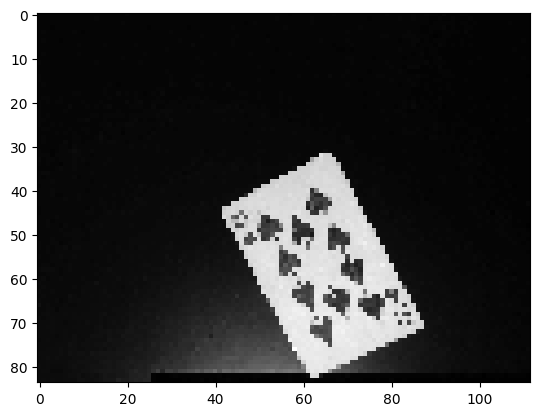

15 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


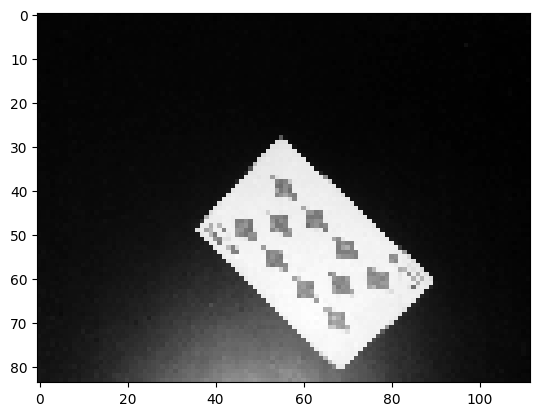

16 - Prediccion:  Picas  | Valor real:  Picas   |Image:


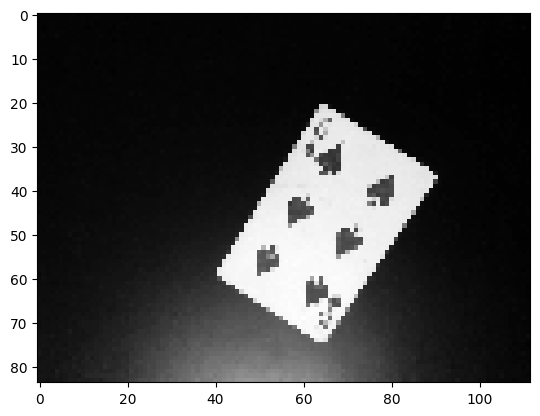

17 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


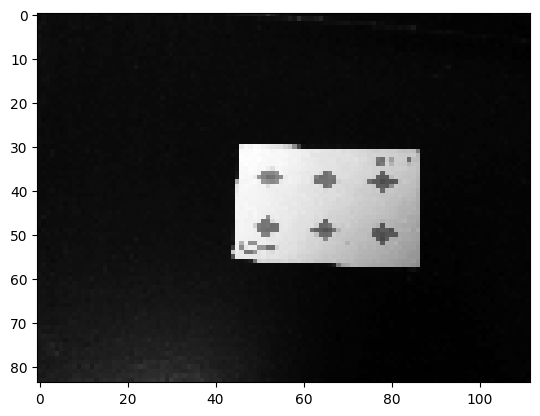

18 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


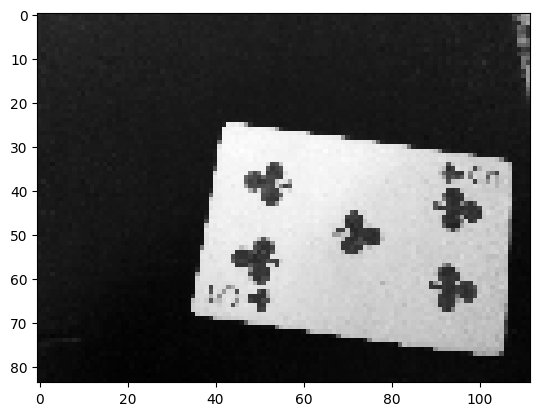

19 - Prediccion:  Picas  | Valor real:  Picas   |Image:


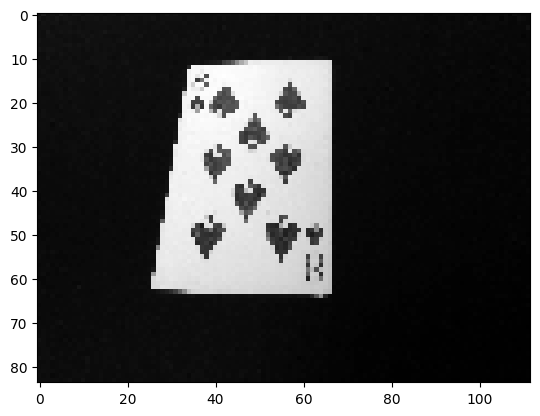

20 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


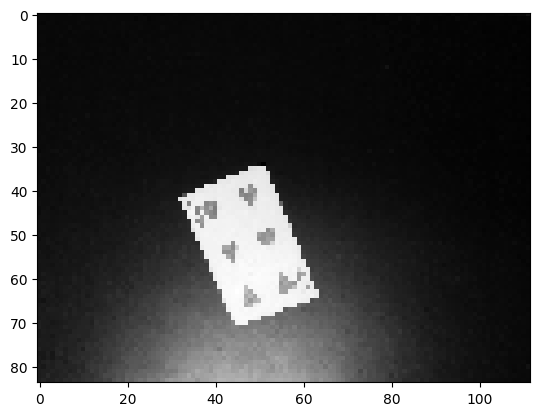

21 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


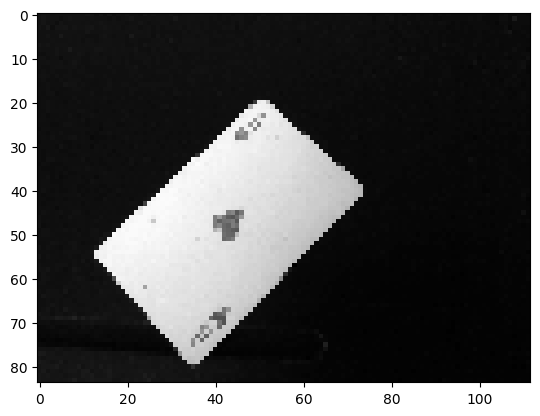

22 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


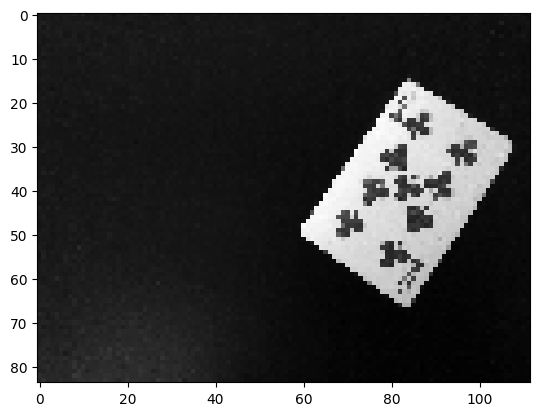

23 - Prediccion:  Picas  | Valor real:  Picas   |Image:


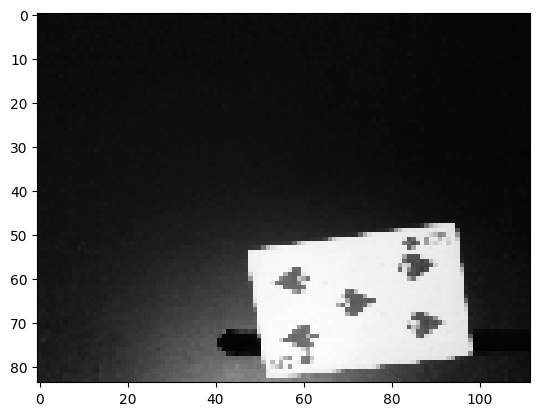

24 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


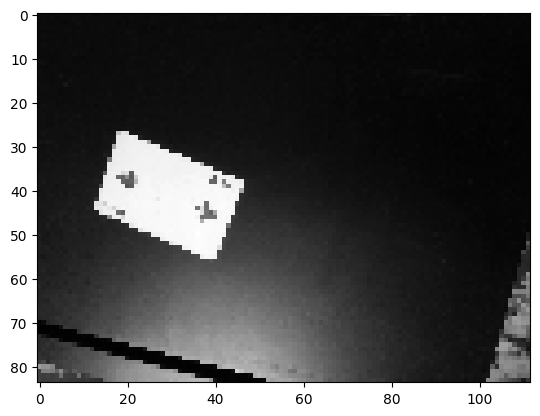

25 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


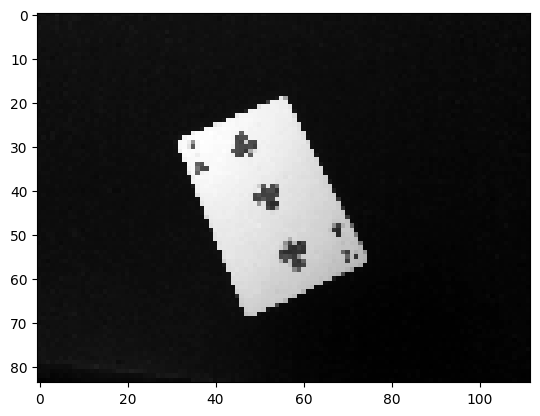

26 - Prediccion:  Picas  | Valor real:  Picas   |Image:


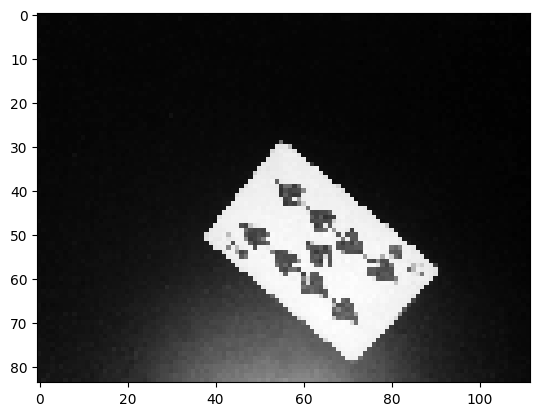

27 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


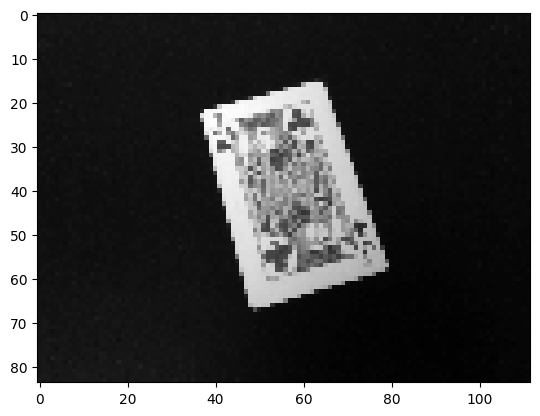

28 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


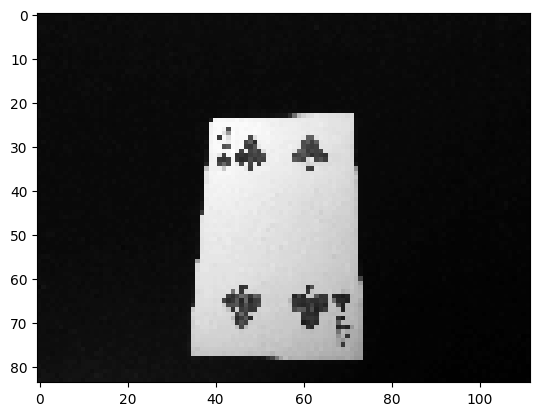

29 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


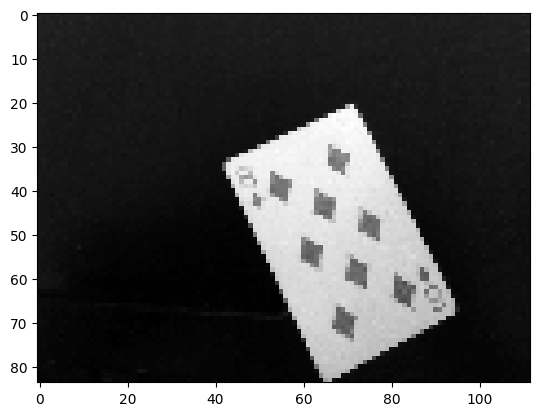

30 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


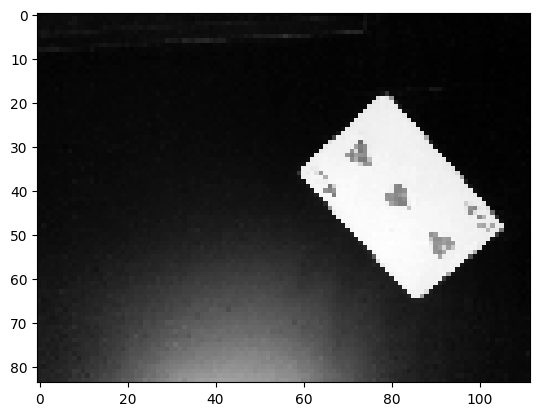

31 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


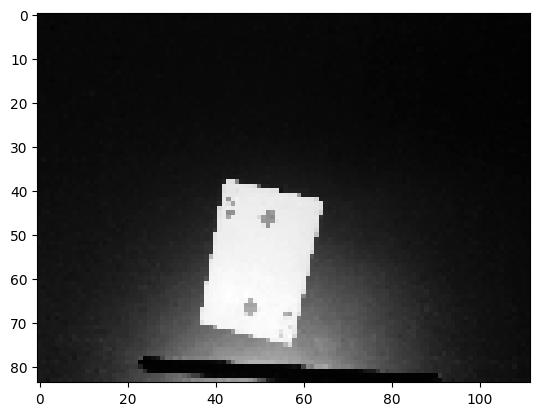

32 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


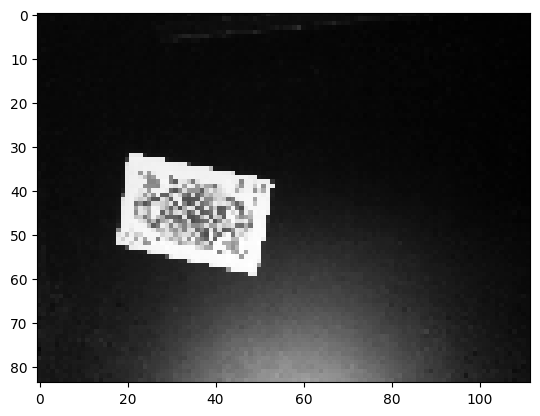

33 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


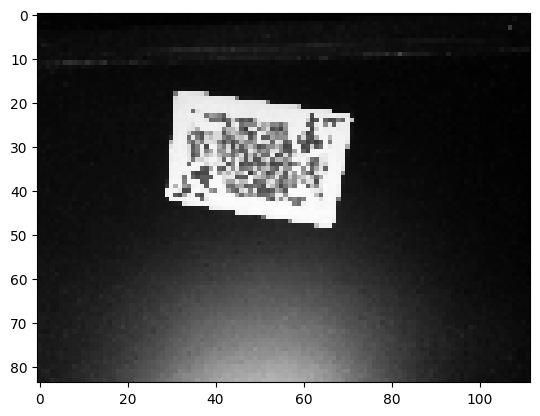

34 - Prediccion:  Picas  | Valor real:  Picas   |Image:


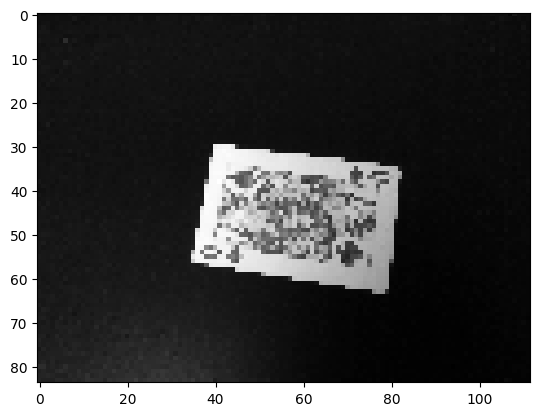

35 - Prediccion:  Picas  | Valor real:  Picas   |Image:


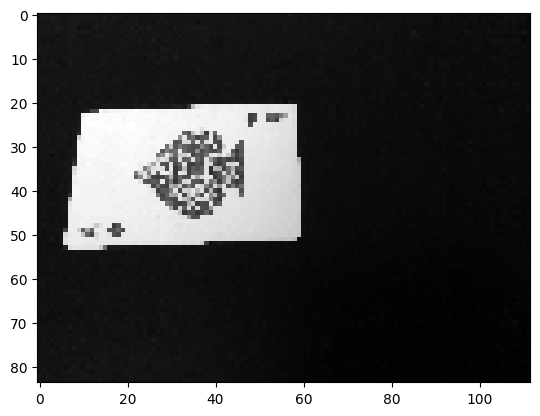

36 - Prediccion:  Picas  | Valor real:  Picas   |Image:


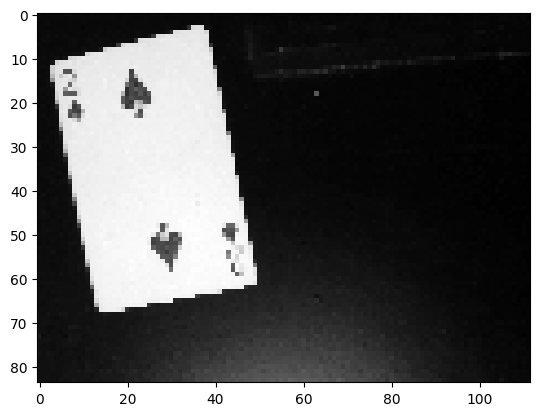

37 - Prediccion:  Picas  | Valor real:  Picas   |Image:


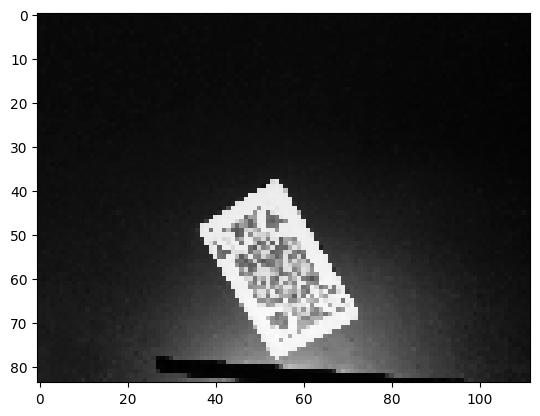

38 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


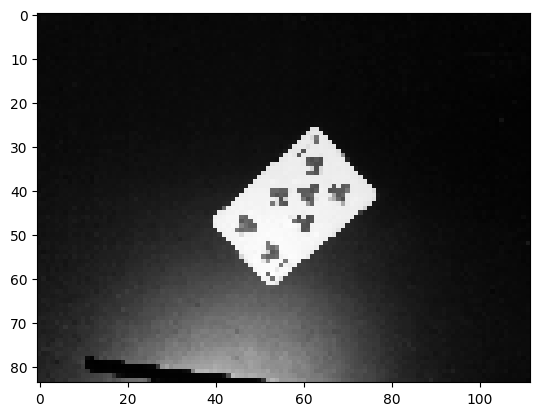

39 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


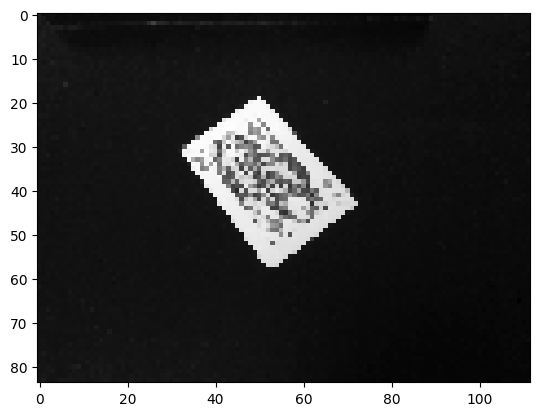

40 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


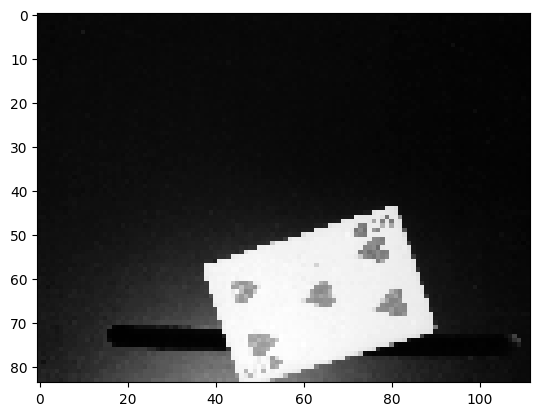

41 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


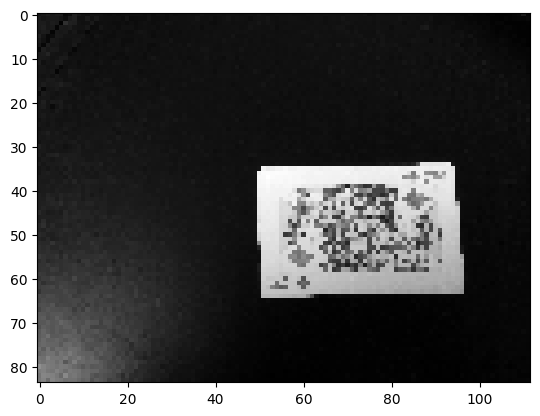

42 - Prediccion:  Picas  | Valor real:  Picas   |Image:


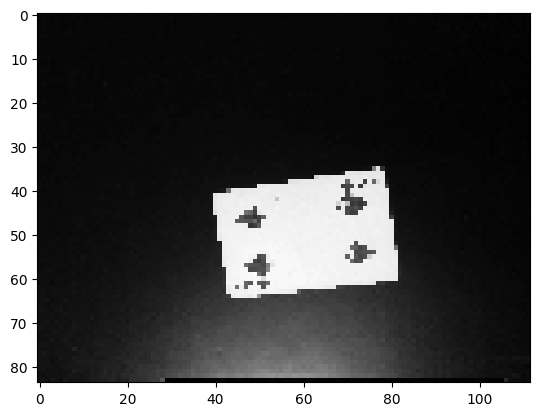

43 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


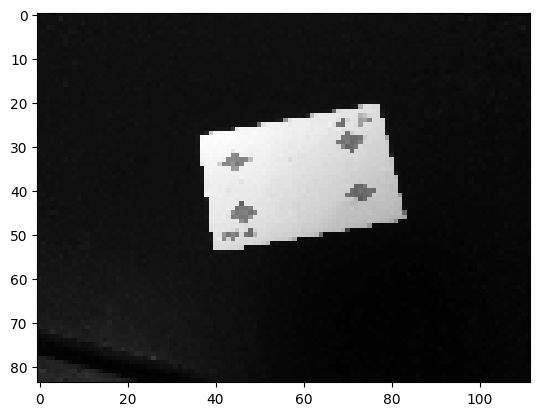

44 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


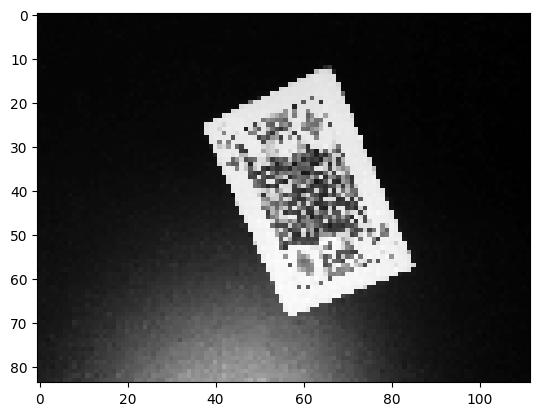

45 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


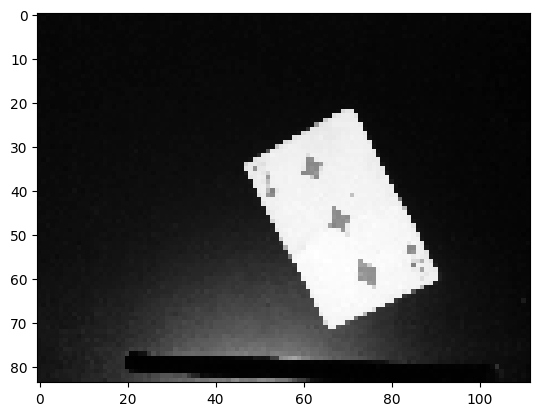

46 - Prediccion:  Corazones   | Valor real:  Diamante   |Image:


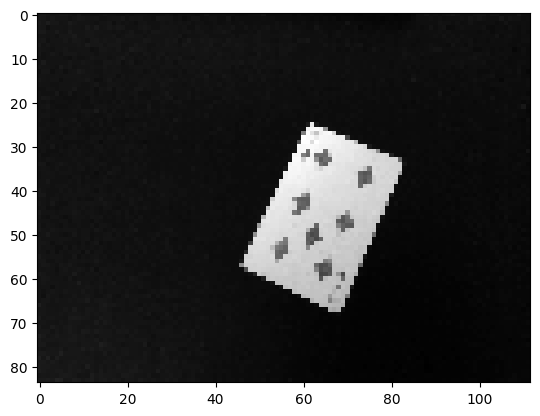

47 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


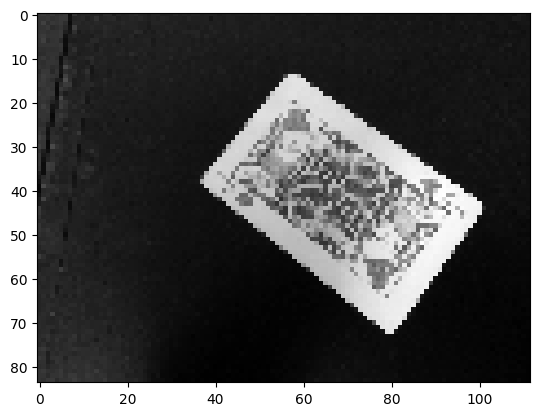

48 - Prediccion:  Trébol  | Valor real:  Trébol   |Image:


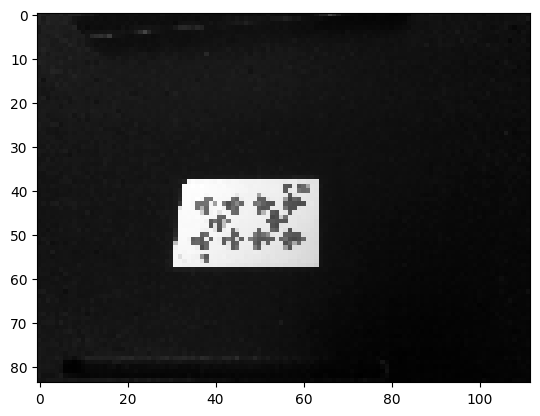

49 - Prediccion:  Corazones   | Valor real:  Corazones    |Image:


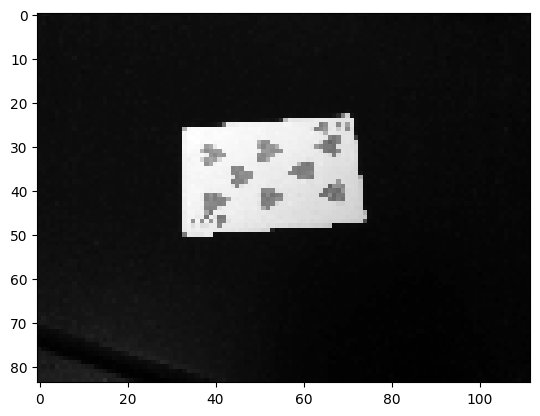

In [33]:
for i in range(1,50):
  print(i,'- Prediccion: ', GetPred(a[i]),' | Valor real: ', GetPred(outputs_type[i]), '  |Image:')
  plt.imshow(utils.array_to_img(img_array[i]), cmap='gray')
  plt.show()

##Feature Extraction

In [34]:
#path = ''
#img = utils.img_to_array(ReadImage('2C7'))
img = img_array[36]
img = np.moveaxis(img[:, None], 0, 1)

In [35]:
import keras
intermediate_layer_model = keras.Model(inputs=model_type.input,
                                       outputs=model_type.layers[0].output)
intermediate_output = intermediate_layer_model(img)
intermediate_output=np.moveaxis(intermediate_output, 0, -1)

In [36]:
intermediate_output.shape

(80, 108, 90, 1)

En la siguientes imagenes podemos ver el output de la primera convolutional layerpara poder entendere mejor que es lo que esta haciendo. Al parecer la CNN esta usando principalmente los tonos de gris para inferir en el tipo de carta. Ya que esto le permite determinar si una carta tenia formas rojas o negras. Luego utilisa el resto de la informacion para determinar el tipo exacto. Por eso no se notan formas exactas dentro de la CNN. Esto es malo ya que no todos los mazos de poker tienen el mismop color y queremos que determine el tipo atravez de la forma.

Algo que se puede hacer para solucionar esto es agregar cartas de distintos colores al dataset para que el color no importe a la hora de predecir.

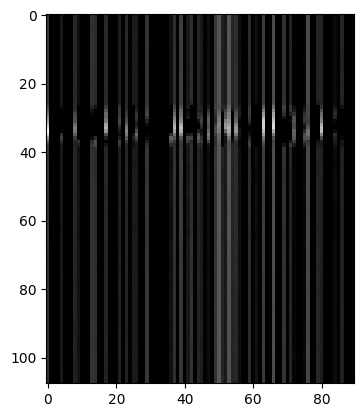

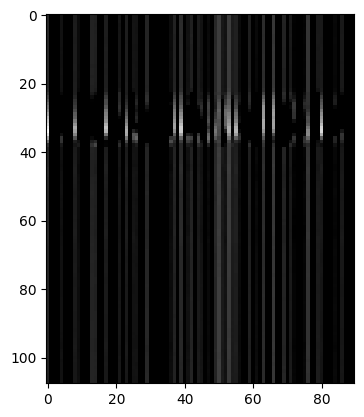

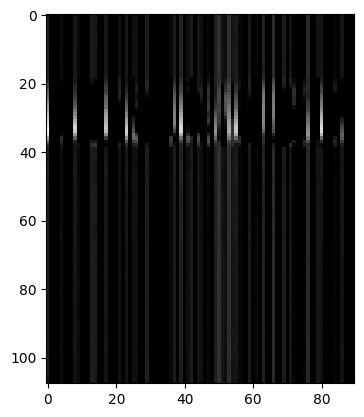

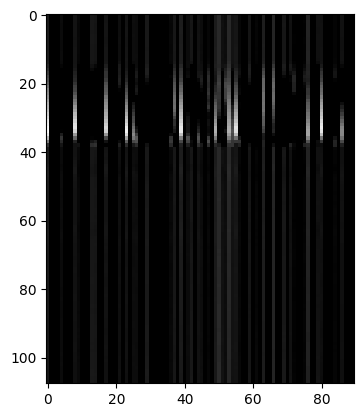

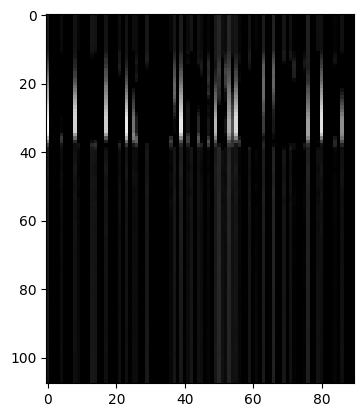

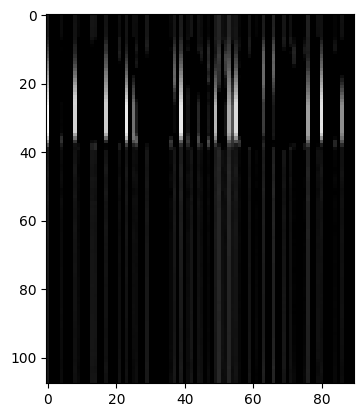

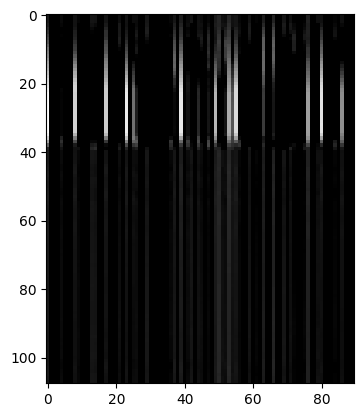

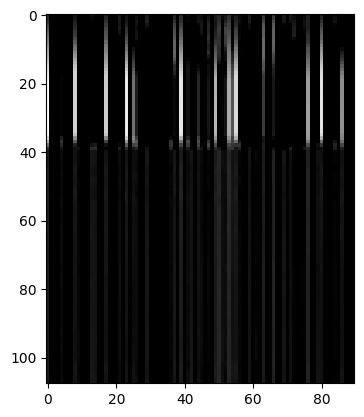

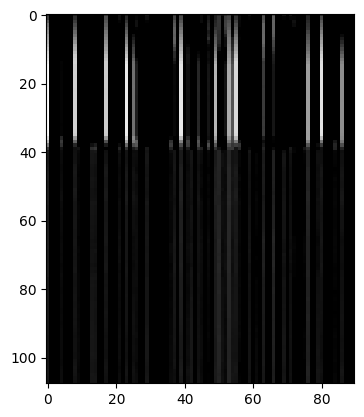

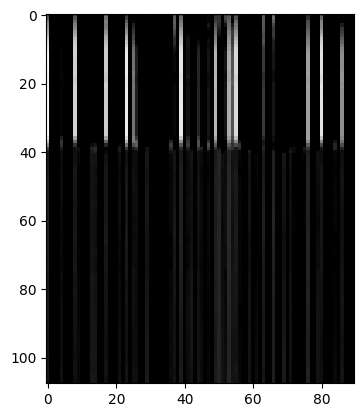

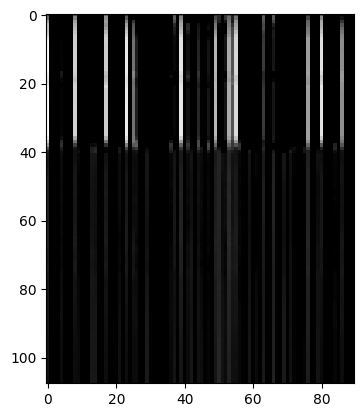

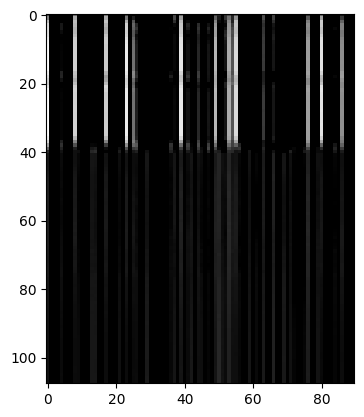

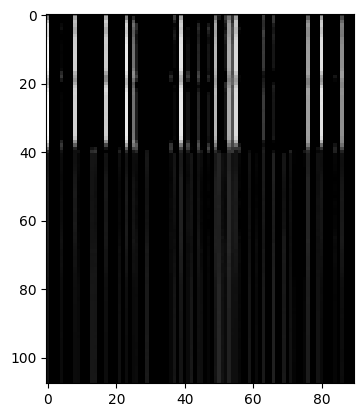

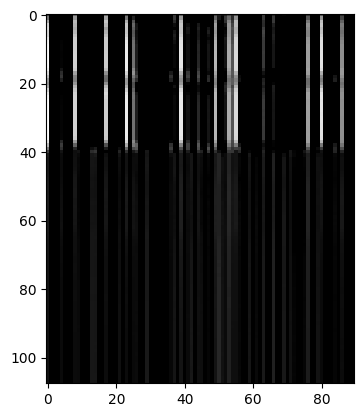

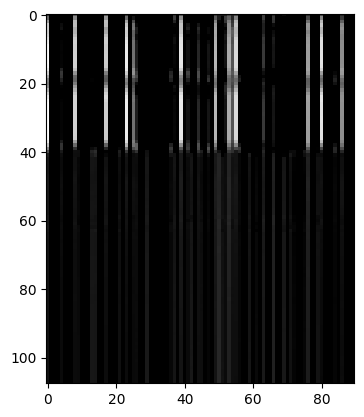

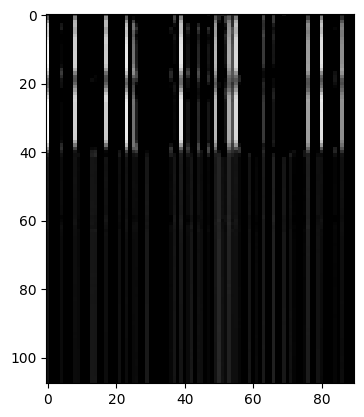

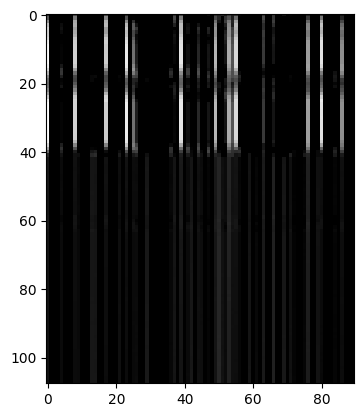

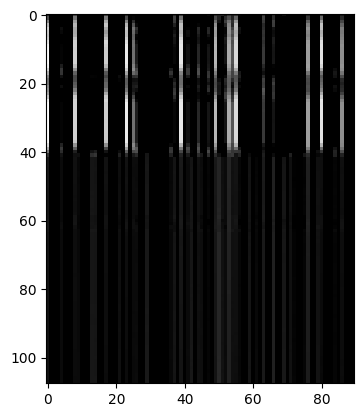

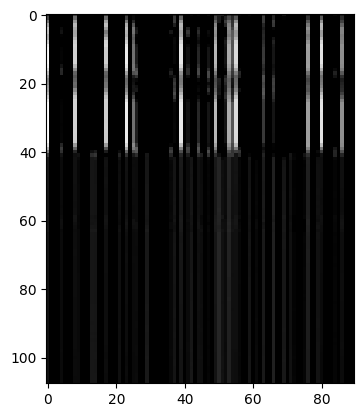

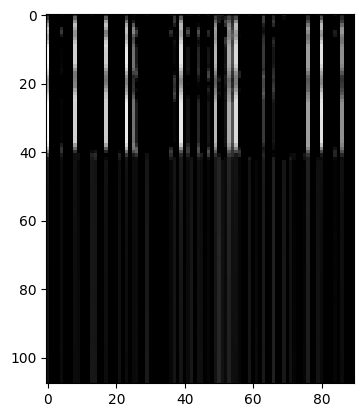

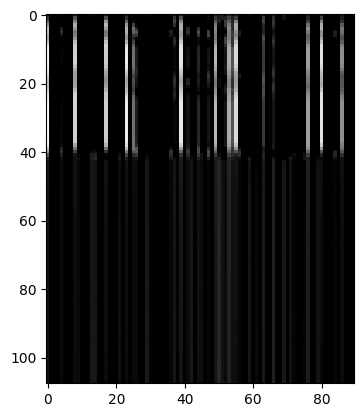

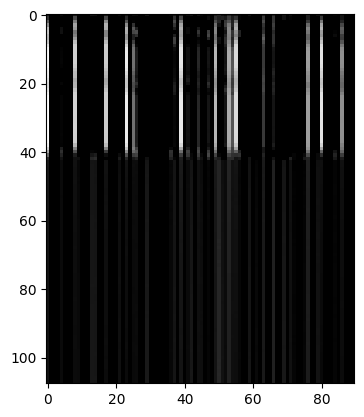

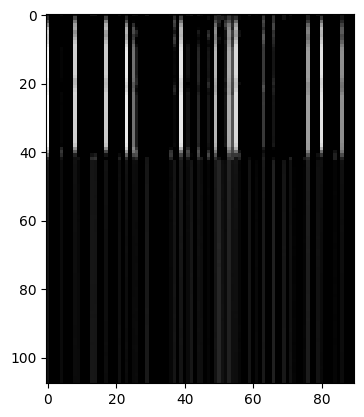

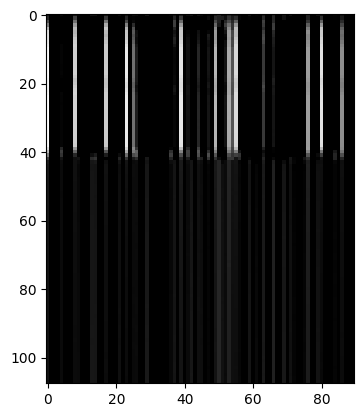

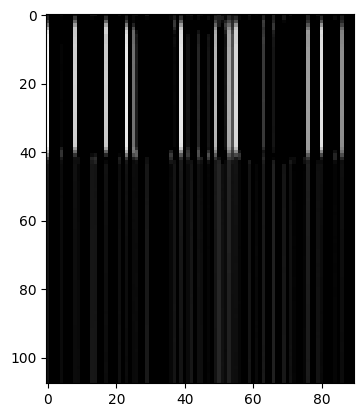

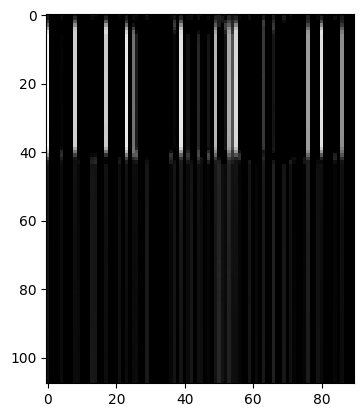

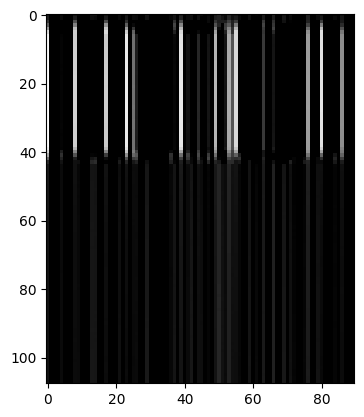

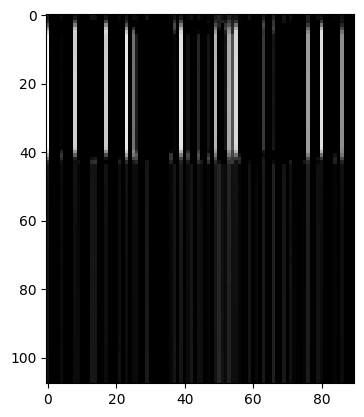

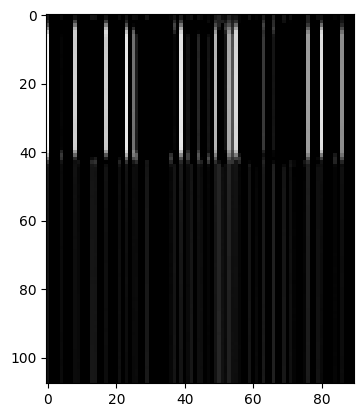

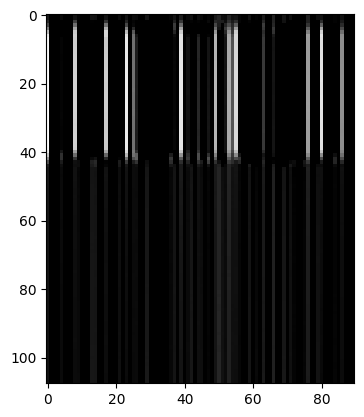

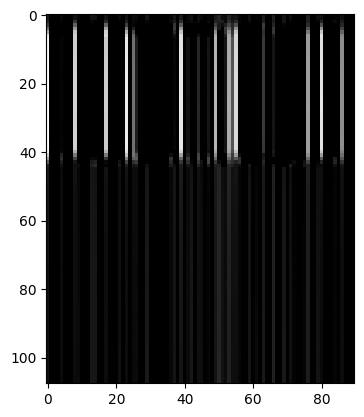

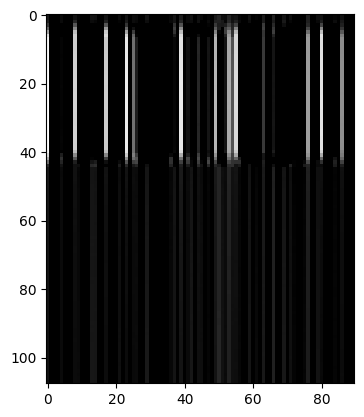

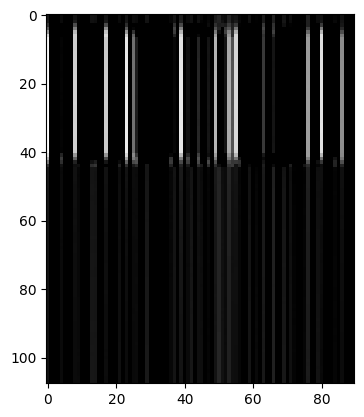

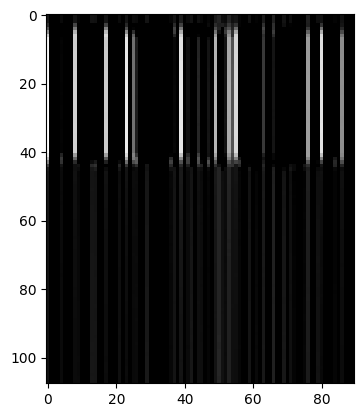

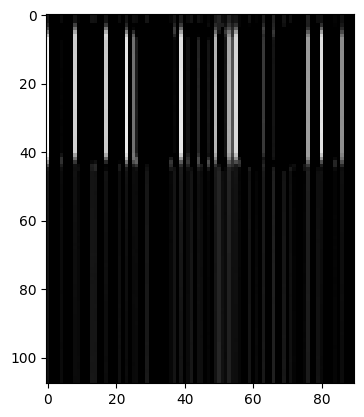

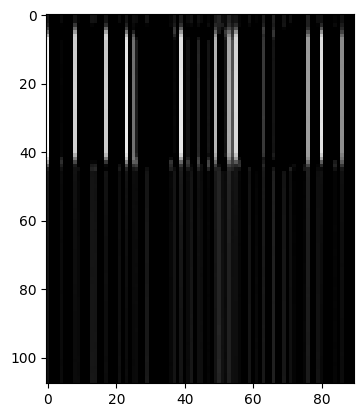

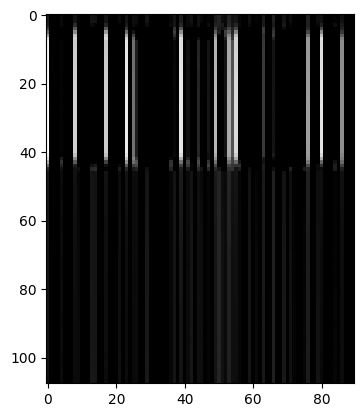

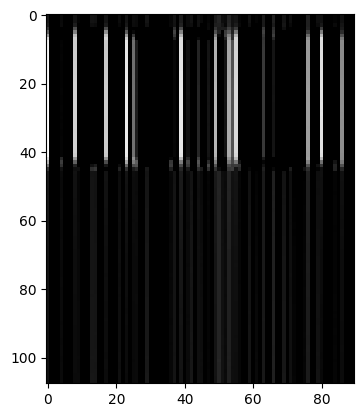

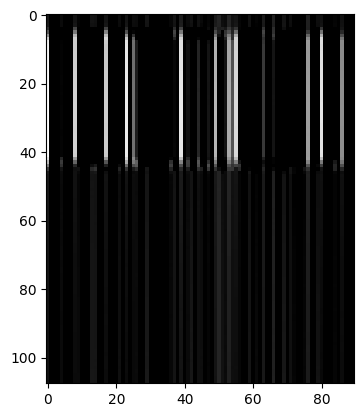

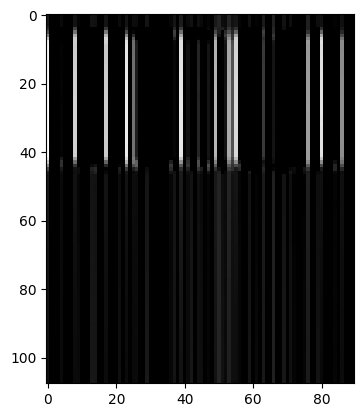

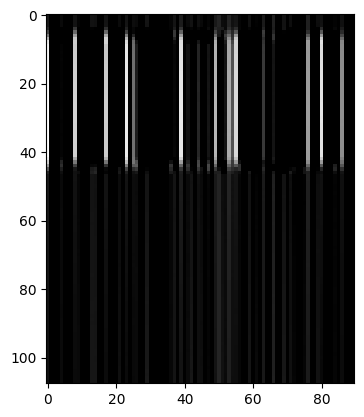

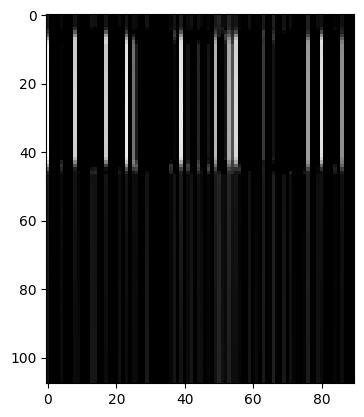

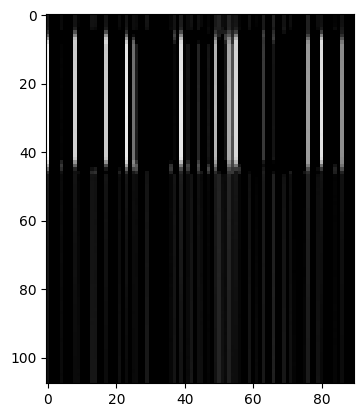

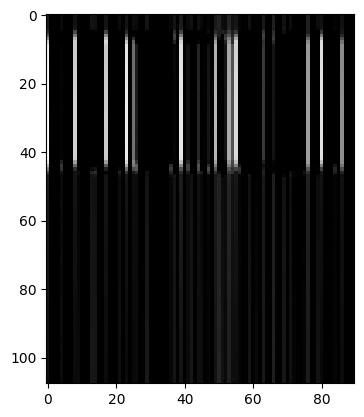

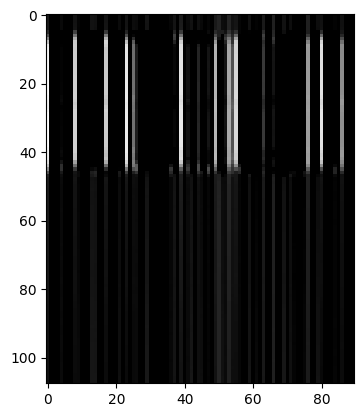

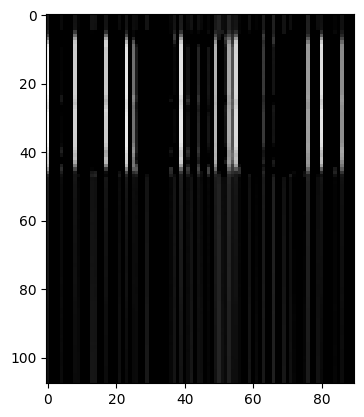

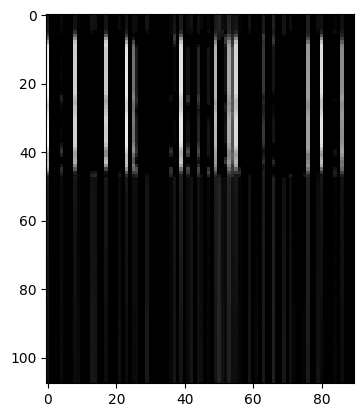

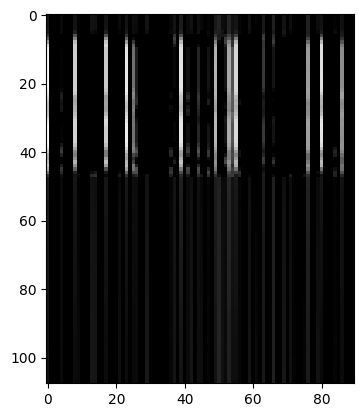

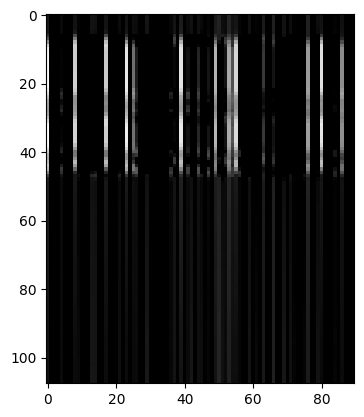

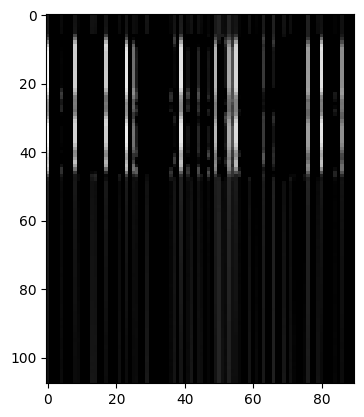

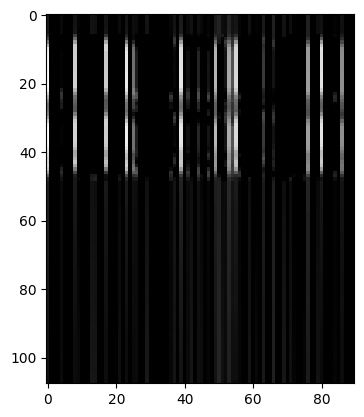

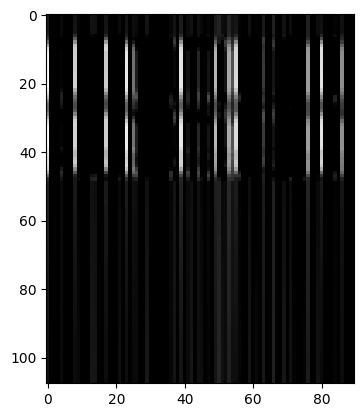

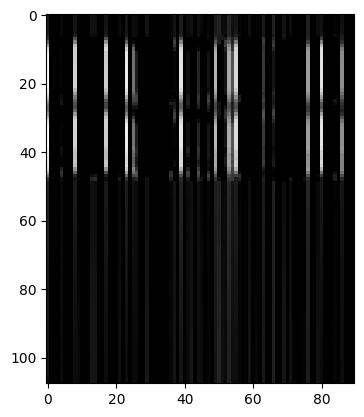

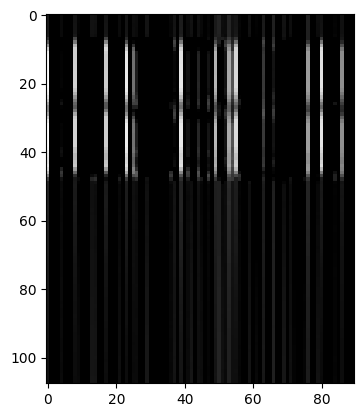

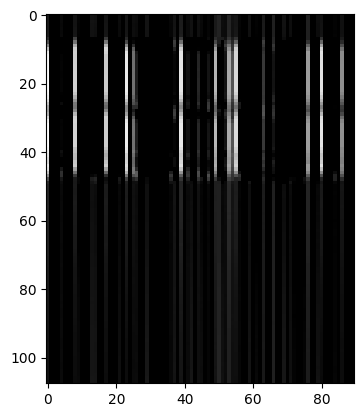

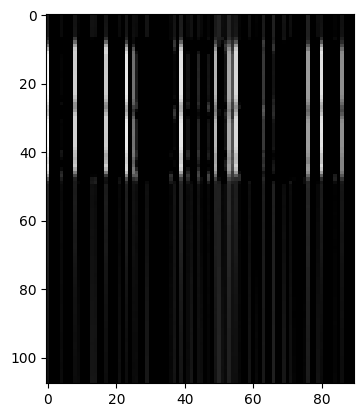

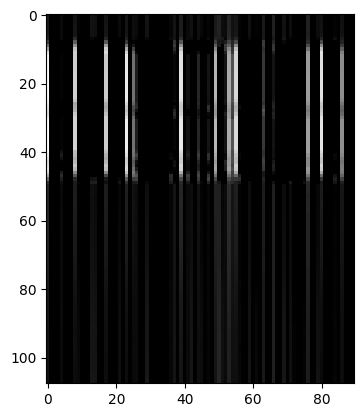

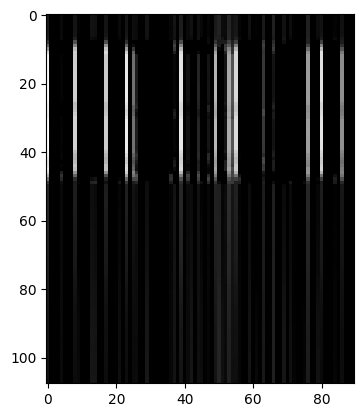

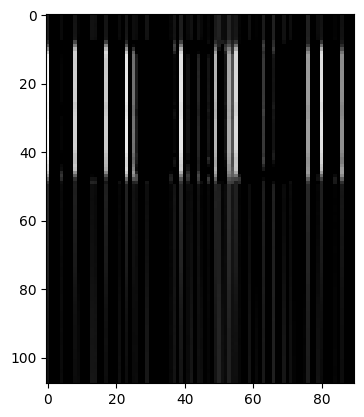

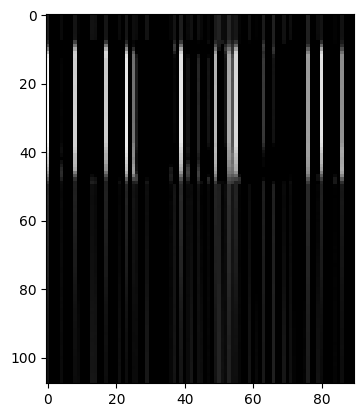

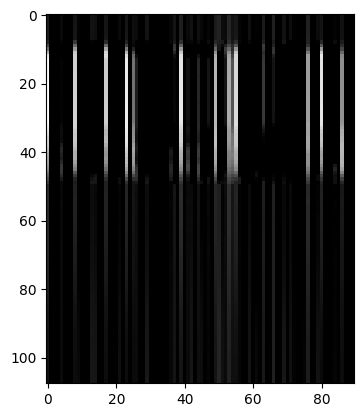

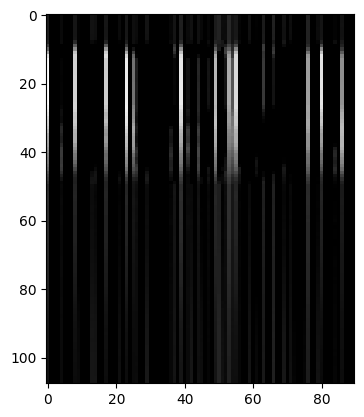

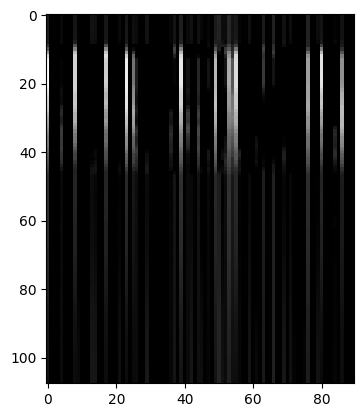

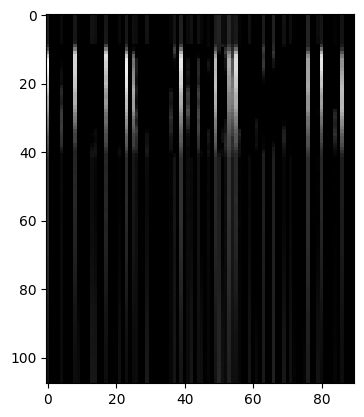

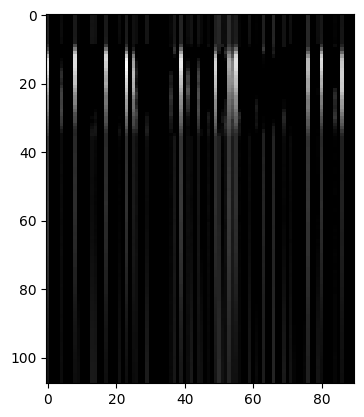

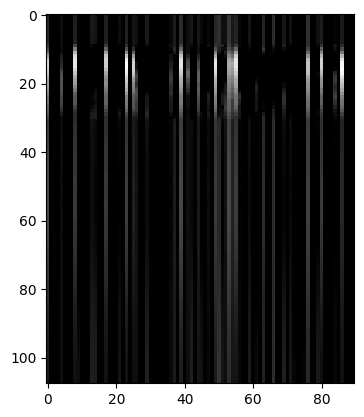

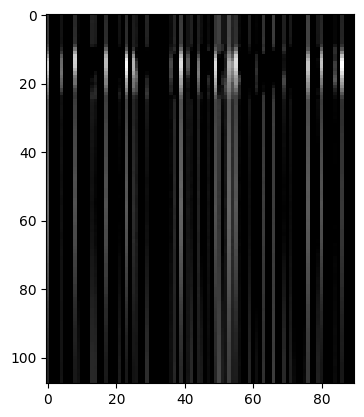

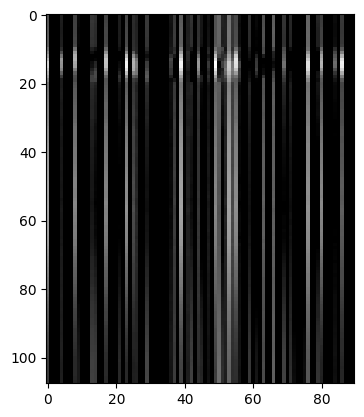

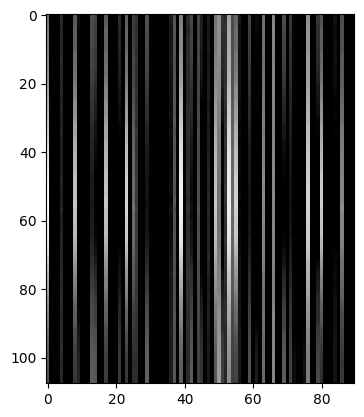

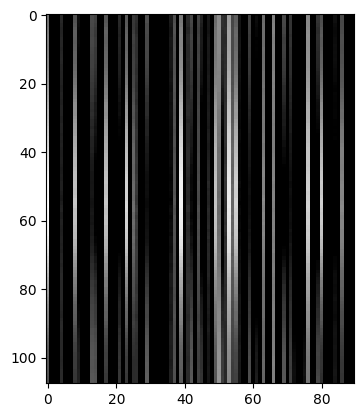

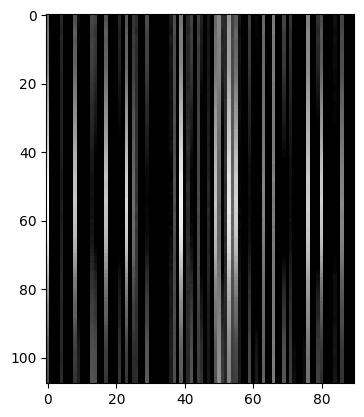

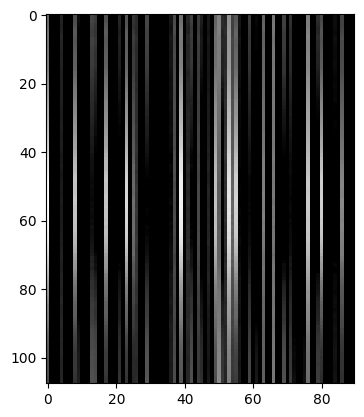

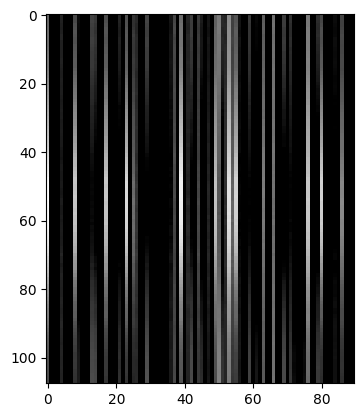

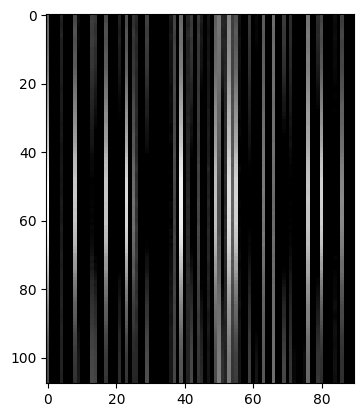

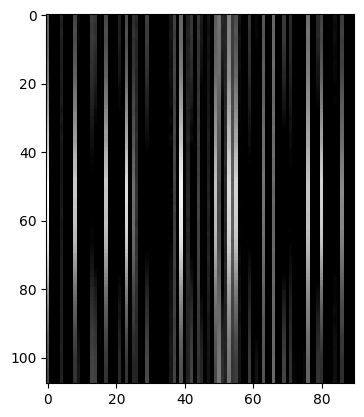

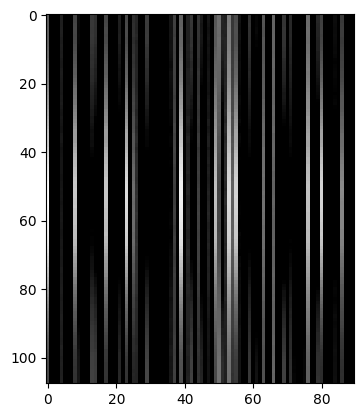

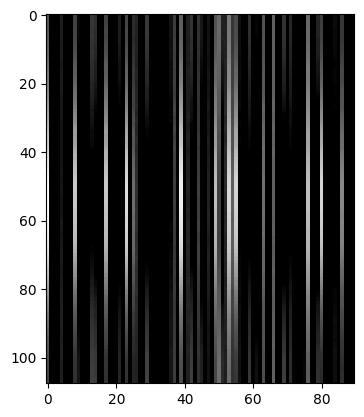

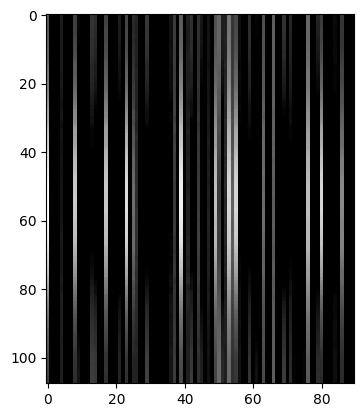

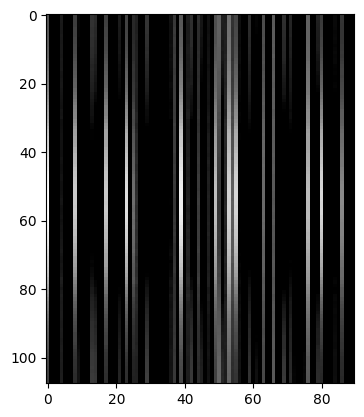

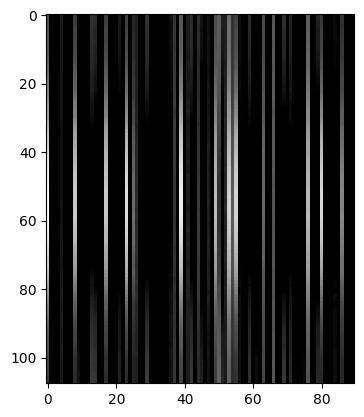

In [37]:
for i in range(intermediate_output.shape[0]):
  plt.imshow(utils.array_to_img(intermediate_output[i]), cmap='gray')
  plt.show()